In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
from selenium.webdriver.common.action_chains import ActionChains
import time
import pandas as pd
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from decimal import Decimal
from selenium.webdriver.common.keys import Keys
import sys
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick
from sklearn.neighbors import KNeighborsRegressor

----------------------------------------------------------------------------------Data Scraping--------------------------------------------------------------------------------------------

##### Data scraping – part 1:

We scrape the current ranking of countries to determine the ranking of the leagues. The data is taken from the table of current ranking in Men’s association coefficient part.
In addition, we change the names of 3 countries to match them with the names of the countries as shown on the Transfermarkt website.
Then, each country is scored as follows:
•	Top 5 countries – factor of 2.0.
•	The countries ranked from 6th place to 22nd – factor of 1.5.
•	Other countries – factor of 1.0.
Source: second note in https://en.wikipedia.org/wiki/European_Golden_Shoe.

In [ ]:
website3 = 'https://en.wikipedia.org/wiki/UEFA_coefficient#Current_ranking'
path3 = '/Users/eyalavni/Downloads/chromedriver'
driver3 = webdriver.Chrome(path3)
driver3.get(website3)

In [ ]:
countries = driver3.find_elements(By.XPATH, '//*[@id="mw-content-text"]/div[1]/table[9]/tbody/tr/td[4]/span[1]/a')
countries_lst = []

for i in countries:
    countries_lst.append(i.get_attribute("title"))

countries_lst[countries_lst.index("Republic of Ireland")] = "Ireland"
countries_lst.pop(countries_lst.index("Liechtenstein"))
countries_lst[countries_lst.index("Football Association of Bosnia and Herzegovina")] = "Bosnia-Herzegovina"
countries_lst[countries_lst.index("Georgia (country)")] = "Georgia"

In [ ]:
coefficients = []

for i in range(54):
    if i < 5:
        coefficients.append(2.0)
    elif (i >= 5) and (i < 22):
        coefficients.append(1.5)
    else:
        coefficients.append(1.0)

print(coefficients)

In [ ]:
df_league_coefficients = pd.DataFrame({"country" : countries_lst, "coefficient" : coefficients})

##### Data scraping – part 2:

In this part, we scrape personal data of each player.
In the first step, we scrape the following data for each league:
•	League name
•	Country name
•	League link (will be used for the second step)
•	League value (will be used later for calculating the average value of each player according to the league in which he plays)
The data is saved in a Data frame and in lists.
In the second step, we scrape from each league the following data for each player:
•	Player name
•	Position
•	Club name
•	Nationality
•	Age
•	Market value
•	Link to player page in Transfermarkt (will be used in data scraping – part 3)
In addition, we add for each player the following data (that scraped before):
•	League coefficient
•	League name
•	League value
•	Country name
All data is stored in a data frame after deleting duplicates due to some cases that a player’s data has been scraped several times.
Also, the players split into 2 data frames as follows:
•	Goalkeepers dataframe – includes all players who have “Goalkeeper” string in “Position” column.
•	Players dataframe – includes all other players who do not appear in the ‘Goalkeepers dataframe’. 


In [ ]:
website = 'https://www.transfermarkt.com/wettbewerbe/europa'
path = '/Users/eyalavni/Downloads/chromedriver'
driver = webdriver.Chrome(path)
driver.get(website)

WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it(driver.find_element(By.CSS_SELECTOR, "#sp_message_iframe_764226")))
driver.find_element(By.XPATH, '//button[@title="ACCEPT ALL"]').click()

In [ ]:
def scraping_league_basic_data():
    league_names = []
    country_names = []
    name_league_links = []
    league_values = []

    next_page_element = driver.find_element(By.XPATH, '//div[@class="pager"]/ul/li[11]/a')
    for i in range(3): 
        time.sleep(5)
        name_league =  driver.find_elements(By.XPATH, '//table[@class="inline-table"]/tbody/tr/td[2]/a')
        country_league = driver.find_elements(By.CLASS_NAME, 'flaggenrahmen')
        league_value = driver.find_elements(By.XPATH, '//table[@class="items"]/tbody/tr/td[8]')

        for j in name_league:
            league_names.append(j.text.split("\n")[0])
            name_league_links.append(j.get_attribute("href"))
        for k in country_league:
            country_names.append(k.get_attribute("title").split("\n")[0])
        for v in league_value:
            league_values.append(v.get_attribute("textContent"))

        time.sleep(5)
        next_page_element.click()
        time.sleep(5)
        next_page_element = driver.find_element(By.XPATH, '//div[@class="pager"]/ul/li[13]/a')
    return league_names, country_names, name_league_links, league_values

In [ ]:
fix_league_names, fix_country_names, fix_name_league_links, fix_league_values = scraping_league_basic_data()

fix_country_names = (list(dict.fromkeys(fix_country_names)))

df = pd.DataFrame({"league_names" : fix_league_names, "country_names" : fix_country_names, "league_links" : fix_name_league_links, "league_values": fix_league_values})
df2 = df.drop_duplicates(subset=["country_names"]).copy()

fix_league_names = list(df2["league_names"])
fix_country_names = list(df2["country_names"])
fix_name_league_links = list(df2["league_links"])
fix_league_values = list(df2["league_values"])

In [ ]:
def webDriverToList(lst, webDri_lst):
    for i in webDri_lst:
        lst.append(i.text.split("\n")[0])
    
    return lst

def textOfImg(lst, webDri_lst):
    for i in webDri_lst:
        lst.append(i.get_attribute("title").split("\n")[0])
    
    return lst

def webDriverLinks(lst, webDri_lst):
    for i in webDri_lst:
        lst.append(i.get_attribute("href"))
    return lst

In [ ]:
final_players = []
final_position = []
final_club = []
final_market_value = []
final_nationality = []
final_age = []
final_players_link = []
final_coeff = []
final_league_name = []
final_league_value = []
final_country_name=[]

In [ ]:
while len(fix_name_league_links) > 0:
    players = []
    position = []
    club = []
    market_value = []
    nationality = []
    age = []
    players_link = []
    coeff = []
    league_value = []
    club_value = []

    driver.get(fix_name_league_links[0])
    
    index = fix_country_names.index(fix_country_names[0])
    league_name = fix_league_names[0]
    country_name = fix_country_names[0]
    league_value = fix_league_values[0]

    time.sleep(5)
    element_tmp = driver.find_element(By.XPATH, '//div[@class="subnavi_box"]/nav/ul/li[5]/a')
    hover = ActionChains(driver).move_to_element(element_tmp).perform()
    time.sleep(5)
    driver.find_element(By.XPATH, '//div[@class="subnavi_box"]/nav/ul/li[5]/div/div/div/ul/li[1]/a[1]').click()
    time.sleep(5)
    driver.find_element(By.XPATH, '//div[@class="tm-tabs"]/a[2]').click()

    page_title1 = driver.find_elements(By.XPATH, '//div[@class="pager"]/ul/li/a')
    if len(page_title1) != 0:
        page_title = page_title1[len(page_title1)-1]
        count_temp = page_title.get_attribute("title").split(' ')[5]
        page_count = int(count_temp.split(')')[0])
        temp_next_page = driver.find_elements(By.XPATH, '//div[@class="pager"]/ul/li/a')
        next_page_element1 = temp_next_page[len(temp_next_page)-2]
    else:
        page_count = 1

    for i in range(page_count):
        time.sleep(5)
        pla_temp = driver.find_elements(By.XPATH, '//td[@class="hauptlink"]/a')
        time.sleep(5)
        pos_temp = driver.find_elements(By.XPATH, '//table[@class="inline-table"]/tbody/tr[2]/td')
        time.sleep(5)
        clu_temp = driver.find_elements(By.XPATH, '//td[@class="zentriert"]/a')
        time.sleep(5)
        mar_temp = driver.find_elements(By.XPATH, '//table[@class="items"]/tbody/tr/td[3]')
        time.sleep(5)
        nat_temp = driver.find_elements(By.XPATH, '//td[@class="zentriert"]/img[1]')
        time.sleep(5)
        age_temp = driver.find_elements(By.XPATH, '//table[@class="items"]/tbody/tr/td[7]')

        position = webDriverToList(position, pos_temp)
        players = webDriverToList(players, pla_temp)
        market_value = webDriverToList(market_value, mar_temp)
        age = webDriverToList(age, age_temp)
        club = textOfImg(club, clu_temp)
        nationality = textOfImg(nationality, nat_temp)
        players_link = webDriverLinks(players_link, pla_temp)

        for k in range(len(pla_temp)):
            coeff.append(df_league_coefficients["coefficient"][index])

        if i < (page_count - 1) and page_count != 1:
            time.sleep(3)
            next_page_element1.click()
    
        if i < (page_count - 2) and page_count != 1:
            time.sleep(5)
            temp_next_page = driver.find_elements(By.XPATH, '//div[@class="pager"]/ul/li/a')
            next_page_element1 = temp_next_page[len(temp_next_page)-2]
            
    if len(position) == len(players) == len(market_value) == len(age) == len(club) == len(nationality) == len(players_link) == len(coeff):
        final_players.extend(players)
        final_position.extend(position)
        final_club.extend(club)
        final_market_value.extend(market_value)
        final_nationality.extend(nationality)
        final_age.extend(age)
        final_players_link.extend(players_link)
        final_coeff.extend(coeff)
        for item in range(1,len(position)):
            final_league_value.append(league_value)
            final_league_name.append(league_name)
            final_country_name.append(country_name)
        
    else: 
        sys.exit("Error Message")
    
    fix_league_values.pop(0)
    fix_country_names.pop(0)
    fix_league_names.pop(0)
    fix_name_league_links.pop(0)



In [ ]:
df_full_data = pd.DataFrame({"player" : final_players, "position" : final_position, "club" : final_club, "market_value": final_market_value, "nationality": final_nationality, "age": final_age, "player_link": final_players_link, "coeff":final_coeff, "league_value":final_league_value, "league_name": final_league_name, "country_name": final_country_name})

In [ ]:
df_data_data_no_dups = df_full_data.drop_duplicates().copy()

In [ ]:
df_data_data_no_dups.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-PART-A.csv')

In [ ]:
goallkeeper_df = df_data_data_no_dups[df_data_data_no_dups["position"] == "Goalkeeper"].copy()
players_df = df_data_data_no_dups[df_data_data_no_dups["position"] != "Goalkeeper"].copy()
goallkeeper_df.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-FINAL-Goalkeepers.csv')
players_df.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-FINAL-Players.csv')

##### Data scraping – part 3:

In this part, we scrape statistical data of each player.
First, we scrape the following data for each player in the ‘Players dataframe’:
•	Height
•	Goals
•	Assists
•	Appearances
•	Yellow cards
•	Second yellow cards
•	Red cards
•	Minutes played
All data is stored in a data frame.
Then, the currently data, that scraped, is merged with the data in ‘Players dataframe’.
Secondly, we scrape the following data for each player in the ‘Goalkeepers dataframe’:
•	Height
•	Goals conceded
•	Clean sheets
•	Appearances
•	Yellow cards
•	Second yellow cards
•	Red cards
•	Minutes played


In [ ]:
website2 = 'https://www.transfermarkt.com/wettbewerbe/europa'
path = '/Users/eyalavni/Downloads/chromedriver'
driver2 = webdriver.Chrome(path)
driver2.get(website2)
WebDriverWait(driver2, 10).until(EC.frame_to_be_available_and_switch_to_it(driver2.find_element(By.CSS_SELECTOR, "iframe#sp_message_iframe_732252")))
driver2.find_element(By.XPATH, '//button[@title="ACCEPT ALL"]').click()

---------------------------------------------------------------------------------------Players-------------------------------------------------------------------------------------------

In [ ]:
height = []
goals = []
assists = []
appearances = []
yellow_cards = []
second_yellow_cards = []
red_cards = []
minutes_played = []

In [ ]:
players_links_list = list(players_df["player_link"])

In [ ]:
while len(players_links_list) > 0:

    appearance = None
    goal = None
    assist = None
    yellow_card = None
    second_yellow_card = None
    red_card = None
    minute_played = None
    
    link = players_links_list[0].replace("profil", "leistungsdatendetails")
    link = link + "/saison//verein/0/liga/0/wettbewerb//pos/0/trainer_id/0/plus/1"
    driver2.get(link)
    time.sleep(2)

    height.append(driver2.find_element(By.XPATH, '//ul[@class="data-header__items"][2]/li[1]/span').text)
    time.sleep(1)

    elements = driver2.find_elements(By.XPATH, '//table[@class="items"]/tfoot/tr/td')
    if len(elements) == 0:
        try:
            elements = driver2.find_element(By.XPATH, '//span[@class="empty"]')
        except:
            continue

    if type(elements) == list:
        appearance = elements[5].get_attribute('textContent')
        goal = elements[7].get_attribute('textContent')
        assist = elements[8].get_attribute('textContent')
        yellow_card = elements[12].get_attribute('textContent')
        second_yellow_card = elements[13].get_attribute('textContent')
        red_card = elements[14].get_attribute('textContent')
        minute_played = elements[17].get_attribute('textContent')

    if (appearance != None) and (goal != None) and (assist != None) and (yellow_card != None) and (second_yellow_card != None) and (red_card != None) and (minute_played != None):
        if appearance == '-':
            appearance = 0
        else: 
            appearance = int(appearance)

        if goal == '-':
            goal = 0
        else:
            goal = int(goal)
    
        if assist == '-':
            assist = 0
        else:
            assist = int(assist)
    
        if yellow_card == '-':
            yellow_card = 0
        else:
            yellow_card = int(yellow_card)
    
        if second_yellow_card == '-':
            second_yellow_card = 0
        else:
            second_yellow_card = int(second_yellow_card)
    
        if red_card == '-':
            red_card = 0
        else:
            red_card = int(red_card)
    
        if minute_played == '-':
            minute_played = 0

    minutes_played.append(minute_played)
    appearances.append(appearance)
    red_cards.append(red_card)
    second_yellow_cards.append(second_yellow_card)
    yellow_cards.append(yellow_card)
    assists.append(assist)
    goals.append(goal)


    players_links_list.pop(0)

In [ ]:
df_players_stats = pd.DataFrame({"height":height, "goals" : goals, "assists" : assists, "appearances":appearances, "yellow_cards": yellow_cards, "second_yellow_cards": second_yellow_cards, "red_cards" : red_cards, "minutes_played": minutes_played})

In [ ]:
df_players_stats.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-players-stats.csv')

-------------------------------------------------------------------------------------Goalkeepers-----------------------------------------------------------------------------------------

In [ ]:
goalkeepers_height = []
goalkeepers_goals_conceded = []
goalkeepers_clean_sheets = []
goalkeepers_height = []
goalkeepers_appearances = []
goalkeepers_yellow_cards = []
goalkeepers_second_yellow_cards = []
goalkeepers_red_cards = []
goalkeepers_minutes_played = []

In [ ]:
goalkeepers_links_list = list(goallkeeper_df["player_link"])

In [ ]:
while len(goalkeepers_links_list) > 0:
    appearance = None
    yellow_card = None
    second_yellow_card = None
    red_card = None
    minute_played = None
    goal_conceded = None
    clean_sheet = None
    
    link = goalkeepers_links_list[0].replace("profil", "leistungsdatendetails")
    link = link + "/saison//verein/0/liga/0/wettbewerb//pos/0/trainer_id/0/plus/1"
    driver2.get(link)
    time.sleep(2)

    goalkeepers_height.append(driver2.find_element(By.XPATH, '//ul[@class="data-header__items"][2]/li[1]/span').text)
    time.sleep(1)

    elements = driver2.find_elements(By.XPATH, '//table[@class="items"]/tfoot/tr/td')
    if len(elements) == 0:
        try:
            elements = driver2.find_element(By.XPATH, '//span[@class="empty"]')
        except:
            continue
    #fetch data 
    if type(elements) == list: 
        appearance = elements[5].get_attribute('textContent')
        yellow_card = elements[11].get_attribute('textContent')
        second_yellow_card = elements[12].get_attribute('textContent')
        red_card = elements[13].get_attribute('textContent')
        goal_conceded = elements[14].get_attribute('textContent')
        clean_sheet = elements[15].get_attribute('textContent')
        minute_played = elements[16].get_attribute('textContent')

    if (appearance != None) and (yellow_card != None) and (second_yellow_card != None) and (red_card != None) and (minute_played != None) and (goal_conceded != None) and (clean_sheet != None):
        if appearance == '-':
            appearance = 0
        else: 
            appearance = int(appearance)

        if yellow_card == '-':
            yellow_card = 0
        else:
            yellow_card = int(yellow_card)

        if second_yellow_card == '-':
            second_yellow_card = 0
        else:
            second_yellow_card = int(second_yellow_card)

        if red_card == '-':
            red_card = 0
        else:
            red_card = int(red_card)

        if goal_conceded == '-':
            goal_conceded = 0
        else:
            goal_conceded = int(goal_conceded)

        if clean_sheet == '-':
            clean_sheet = 0
        else:
            clean_sheet = int(clean_sheet)

        if minute_played == '-':
            minute_played = 0

    goalkeepers_appearances.append(appearance)
    goalkeepers_yellow_cards.append(yellow_card)
    goalkeepers_second_yellow_cards.append(second_yellow_card)
    goalkeepers_red_cards.append(red_card)
    goalkeepers_goals_conceded.append(goal_conceded)
    goalkeepers_clean_sheets.append(clean_sheet)
    goalkeepers_minutes_played.append(minute_played)

    goalkeepers_links_list.pop(0)

In [ ]:
df_goalkeepers_stats = pd.DataFrame({"height" : goalkeepers_height, "appearances" : goalkeepers_appearances, "goals_conceded":goalkeepers_goals_conceded, "clean_sheets": goalkeepers_clean_sheets, "yellow_cards": goalkeepers_yellow_cards, "second_yellow_cards" : goalkeepers_second_yellow_cards, "red_cards": goalkeepers_red_cards, 'minutes_played': goalkeepers_minutes_played})

In [ ]:
df_goalkeepers_stats.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-goalkeepers-stats.csv')

In [ ]:
df_players_union = pd.concat([players_df,df_players_stats], axis=1)
df_goalkeepers_union = pd.concat([goallkeeper_df,df_goalkeepers_stats], axis=1)

In [ ]:
df_players_union.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-PLAYERS-UNION.csv')
df_goalkeepers_union.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-GOALKEEPERS-UNION.csv')

##### Data scraping – part 4:

In this part, we scrape club values in order to add them for each player.
For each league, the value of the clubs will be collected, and will be stored in a dataframe that also includes:
•	Club name
•	League name
•	Country name
Then, we will add for each player the value of the club he plays in and the name of the country of the league he plays in.

In [ ]:
website = 'https://www.transfermarkt.com/wettbewerbe/europa'
path = '/Users/eyalavni/Downloads/chromedriver'
driver = webdriver.Chrome(path)
driver.get(website)
WebDriverWait(driver, 10).until(EC.frame_to_be_available_and_switch_to_it(driver.find_element(By.CSS_SELECTOR, "#sp_message_iframe_764226")))
driver.find_element(By.XPATH, '//button[@title="ACCEPT ALL"]').click()

In [ ]:
fix_league_names, fix_country_names, fix_name_league_links, fix_league_values = scraping_league_basic_data()

In [ ]:
df = pd.DataFrame({"league_names" : fix_league_names, "country_names" : fix_country_names, "league_links" : fix_name_league_links, "league_values" : fix_league_values})
df2 = df.drop_duplicates(subset=["country_names"]).copy()

fix_league_names = list(df2["league_names"])
fix_country_names = list(df2["country_names"])
fix_name_league_links = list(df2["league_links"])

In [ ]:
final_clubs_names = []
final_leagues_names = []
final_country_names = []
final_club_values = []

In [ ]:
while len(fix_name_league_links) > 0:
    club = []
    lea_name = []
    cou_name = []
    club_value = []

    driver.get(fix_name_league_links[0])

    time.sleep(5)

    club_temp = driver.find_elements(By.XPATH, '//div[@class="responsive-table"]/div/table/tbody/tr/td[2]/a[1]')
    club_value_temp = driver.find_elements(By.XPATH, '//div[@class="responsive-table"]/div/table/tbody/tr/td[7]/a')

    for c in club_temp:
        club.append(c.get_attribute("title"))
        lea_name.append(fix_league_names[0])
        cou_name.append(fix_country_names[0])

    for v in club_value_temp:
        club_value.append(v.get_attribute("textContent"))

    if (len(club) == len(lea_name) == len(cou_name) == len(club_value)):
        final_clubs_names.extend(club)
        final_leagues_names.extend(lea_name)
        final_country_names.extend(cou_name)
        final_club_values.extend(club_value)
    else: 
        sys.exit("Error Message")

    fix_name_league_links.pop(0)
    fix_country_names.pop(0)
    fix_league_names.pop(0)

In [ ]:
df_club_values = pd.DataFrame({"club_name" : final_clubs_names, "league_name" : final_leagues_names, "country_name" : final_country_names, "club_value" : final_club_values})

In [ ]:
club_name_lst = list(df_club_values["club_name"])
club_value_lst = list(df_club_values["club_value"])
country_name_lst = list(df_club_values["country_name"])
club_name_lst.append("SS Virtus")
club_value_lst.append(585000)
country_name_lst.append("San Marino")

In [ ]:
def add_club_value(df):
    final_club_value = []
    final_country_name = []

    for p in df["club"]:
        index3 = club_name_lst.index(p)
        final_club_value.append(club_value_lst[index3])
        final_country_name.append(country_name_lst[index3])
    df["club_value"] = final_club_value
    df["country_name"] = final_country_name
    return df.copy()

In [ ]:
df_players_union = add_club_value(df_players_union)
df_goalkeepers_union = add_club_value(df_goalkeepers_union)

##### craping – part 5:

In this part, we calculate the average value of a player according to the league in which he plays.

First, we will count the amount of players from each league. Then, we will convert the value of the leagues from string variables to int variables. 
Finally, we will calculate the average value of a player by dividing the value of the league by the number of the players playing in the league.

Note: The process described above will be performed once, and placing the club value data will be done for the 2 dataframes: ‘Players dataframe’, ‘Goalkeepers dataframe’.

In [ ]:
lst_count = list(df_players_union["league_country_name"].value_counts())
df2["players_count"] = lst_count

In [66]:
d = {'k':3, 'm':6, 'bn':9}

def int_price(str):
    if ((str[-1] == 'm') or (str[-1] == 'k')):
        price, currency = str[1:-1], str[-1]
        tmp = Decimal(price)
        return tmp * 10 ** d[currency]

    elif (str[-2:] == 'bn'):
        price, currency = str[1:-2], str[-2:]
        tmp = Decimal(price)
        return tmp * 10 ** d[currency]

    else:
        return 0

In [ ]:
lst2 = []

for col in df2["league_values"]:
    lst2.append(int(int_price(col.split(' ')[0])))

df2["league_values"] = lst2

In [ ]:
avg_value = []

for index, i in enumerate(lst2):
    avg_value.append(int(i / lst_count[index]))

df2["avg_value"] = avg_value

In [ ]:
def add_avg_market_value(df):
    country_name = list(df2["country_names"])
    avg_value_by_player = []

    for i in df["country_name"]:
        index4 = country_name.index(i)
        avg_value_by_player.append(df2["avg_value"][index4])
    df["avg_value"] = avg_value_by_player
    return df.copy()

In [ ]:
df_players_union = add_avg_market_value(df_players_union)
df_goalkeepers_union = add_avg_market_value(df_goalkeepers_union)

In [ ]:
df_players_union.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-PLAYERS-UNION-FINAL.csv')
df_goalkeepers_union.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-GOALKEEPERS-UNION-FINAL.csv')

--------------------------------------------------------------------------Data Cleaning And Analysis---------------------------------------------------------------------------------------

##### Data cleaning & analysis – part 1:

Any process performed above will be performed for the dataframes: 'Players dataframe', 'Goalkeepers dataframe'
    
First, we will convert each player’s height data from string type to float. 
It should be noted that not all players have a height value, and as a result incorrect data was collected which we will correct them to None.

We will fill the None values with the average height of the players.

In [487]:
def float_to_int(lst):
    for index, i in enumerate(lst):
        lst[index] = int(i)
    return lst

def parse_columns(data, lst):
    data_copy = data.copy()
    for col in lst:
        data_copy[col] = float_to_int(list(data_copy[col]))
    return data_copy

In [488]:
position_filter_lst = ["Goalkeeper", "Right-Back", "Centre-Back", "Left-Back", "Defensive Midfield", "Right Midfield", "Central Midfield", "Left Midfield", "midfield", "Midfield", "Attacking Midfield", "Right Winger", "Second Striker", "Left Winger", "Centre-Forward", "Forward", "Attack", "Defender"]

In [489]:
def height_str_to_float(hegiht_lst):
    for index, i in enumerate(hegiht_lst):
        if i not in position_filter_lst:
            if "," in i:
                tmp = i.split(' ')[0].replace(',', '.')
            else:
                tmp = i.split(' ')[0].replace("'", '.')
            hegiht_lst[index] = float(tmp)
        else:
            hegiht_lst[index] = None

    return hegiht_lst

In [490]:
fixed_height = height_str_to_float(df_players_union['height'])
df_players_union['height'] = fixed_height
fixed_height = height_str_to_float(df_goalkeepers_union['height'])
df_goalkeepers_union['height'] = fixed_height

/var/folders/2q/0pvpsbfd0h30c9vs575k5tb40000gn/T/ipykernel_24518/483049085.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hegiht_lst[index] = float(tmp)
/var/folders/2q/0pvpsbfd0h30c9vs575k5tb40000gn/T/ipykernel_24518/483049085.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hegiht_lst[index] = None


In [491]:
df_players_union['height'].fillna(value=df_players_union['height'].mean(), axis=0, inplace=True)
df_goalkeepers_union['height'].fillna(value=df_goalkeepers_union['height'].mean(), axis=0, inplace=True)

##### Data cleaning & analysis – part 2:

Second, we will divide the players into 4 categories according to their position:
•	Defensive players – position 1
•	Midfield players – position 2
•	Attack players – position 3
•	Goalkeepers – position 4
The categories replace the position value for each player.

In [492]:
pos_group1 = ["Right-Back", "Centre-Back", "Left-Back", "Defender", "Defence"]
pos_group2 = ["Defensive Midfield", "Right Midfield", "Central Midfield", "Left Midfield", "midfield", "Midfield", "Attacking Midfield"]
pos_group3 = ["Right Winger", "Second Striker", "Left Winger", "Centre-Forward", "Forward", "Attack"]
pos_group4 = ["Goalkeeper"]

In [493]:
def categorize_position(df):
    cate_pos = []
    for i in df["position"]:
        if i in pos_group1:
            cate_pos.append(1)
        elif i in pos_group2:
            cate_pos.append(2)
        elif i in pos_group3:
            cate_pos.append(3)
        else:
            cate_pos.append(4)
    df["position"] = cate_pos
    return df.copy()

In [494]:
df_players_union = categorize_position(df_players_union)
df_goalkeepers_union = categorize_position(df_goalkeepers_union)

##### Data cleaning & analysis – part 3:

In this part, we convert the age column from string type to integer type. 
There are players who do not have an age value, so we will set the value ‘None’ for them.

In [495]:
def convert_age_type(age_lst):
    for index, i in enumerate(age_lst):
        if i == '-':
            age_lst[index] = None
        else:
            age_lst[index] = int(i)
    return age_lst

In [496]:
df_players_union["age"] = convert_age_type(list(df_players_union["age"]))
df_goalkeepers_union["age"] = convert_age_type(list(df_goalkeepers_union["age"]))

##### Data cleaning & analysis – part 4:

In this section, we convert the club values column to a numerical figure, and add to each player the value of the club he plays for.

In [498]:
def convert_club_value(value_lst):
    lst_tmp = []
    for i in value_lst:
        int_value = int(int_price(i))
        lst_tmp.append(int_value)
    return lst_tmp

In [499]:
df_players_union["club_value"] = convert_club_value(df_players_union["club_value"])
df_goalkeepers_union["club_value"] = convert_club_value(df_goalkeepers_union["club_value"])

##### Data cleaning & analysis – part 5:

Now, we convert the “minutes_played” column to numerical figure. 
The data on Transfermarkt website was measured in thousands of minutes (For example: a player who played 1,525 minutes, has a value 1.525 on the website). 
So, we performed a calculation to convert the data into minutes. 
Players, who did not have a value in “minutes_played” column, will receive the value “None” in the conversion process.

In [501]:
def convert_minutes_played(df):
    minutes_played = []
    for i in df["minutes_played"]:
        temp = str(i).split("'")[0]
        if len(temp.split('.')) == 2:
            minutes_played.append(int(temp.split('.')[0])*1000 + int(temp.split('.')[1]))
        elif temp == 'nan':
            minutes_played.append(None)
        else:
            minutes_played.append(int(temp.split('.')[0]))
    df["minutes_played"] = minutes_played
    return df.copy()

In [502]:
df_players_union = convert_minutes_played(df_players_union)
df_goalkeepers_union = convert_minutes_played(df_goalkeepers_union)

##### Data cleaning & analysis – part 6:

In this part, we convert the “market_value” column into a numerical figure. 
The conversion is done with the function ‘int_price(str)’ which receives a string (with a suffix of number), and convert it to numeric value according to the suffix.
Finally, each player will receive the numerical value of the “market_value” figure.

In [504]:
def convert_market_value(df):
    lst = []
    for col in df["market_value"]:
        lst.append(int(int_price(col.split(' ')[0])))
    df["market_value"] = lst
    return df.copy()

In [505]:
df_players_union = convert_market_value(df_players_union)
df_goalkeepers_union = convert_market_value(df_goalkeepers_union)

##### Data cleaning & analysis – part 7:

Now, we will delete rows containing “None” values using the ‘dropna()’ function.

In [609]:
clean_platyers_df = df_players_union.dropna().copy()
clean_goalkeepers_df = df_goalkeepers_union.dropna().copy()

In [596]:
clean_platyers_df = parse_columns(clean_platyers_df,["appearances", "age", "goals", "assists", "yellow_cards", "second_yellow_cards", "red_cards"])
clean_goalkeepers_df = parse_columns(clean_goalkeepers_df,["appearances", "age","goals_conceded", "clean_sheets", "yellow_cards", "second_yellow_cards", "red_cards"])

In [553]:
clean_platyers_df.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-PLAYERS-UNION-FINAL-CLEAN.csv')
clean_goalkeepers_df.to_csv('/Users/eyalavni/Documents/Hit/data sience/project df/TM-GOALKEEPERS-UNION-FINAL-CLEAN.csv')

---------------------------------------------------------------------------visealization and regression------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------Players----------------------------------------------------------------------------------------------

##### Visualization – part 1:

First, we will present a “Heatmap” graph that describes relationships between numeric columns in the dataframe.
The stronger the connection, the brighter the color of the square. The weaker the connection, the darker the color of the square.

/var/folders/2q/0pvpsbfd0h30c9vs575k5tb40000gn/T/ipykernel_24518/1098756508.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(clean_platyers_df.corr())


<AxesSubplot: >

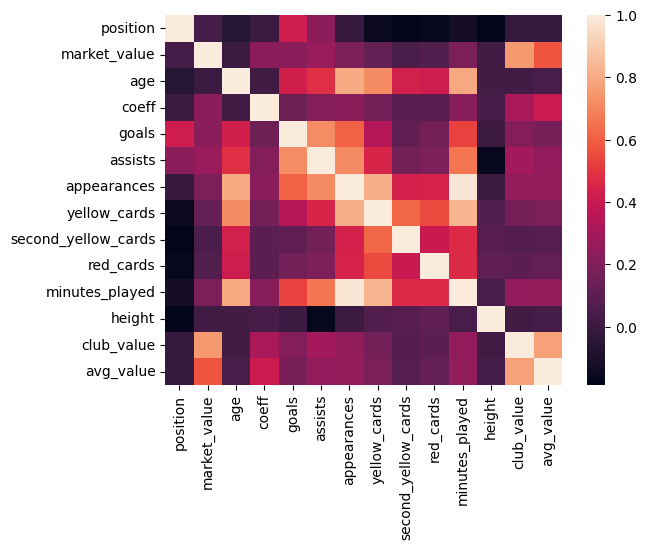

In [740]:
sns.heatmap(clean_platyers_df.corr())

##### Visualization – part 2:

The following histogram graphs describe relationships with “market_value” column:
•	The first graph describes the average market value according to the amount of the appearances.
•	The second graph describes the average market value according to the age.
•	The third graph describes that there are gaps between the market value of each position.

<AxesSubplot: xlabel='appearances'>

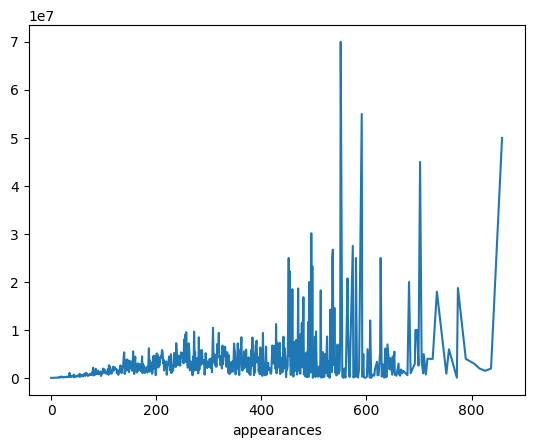

In [741]:
average_appearances = clean_platyers_df.groupby('appearances')['market_value'].mean()
average_appearances.plot(label="Average Income")

<AxesSubplot: xlabel='age'>

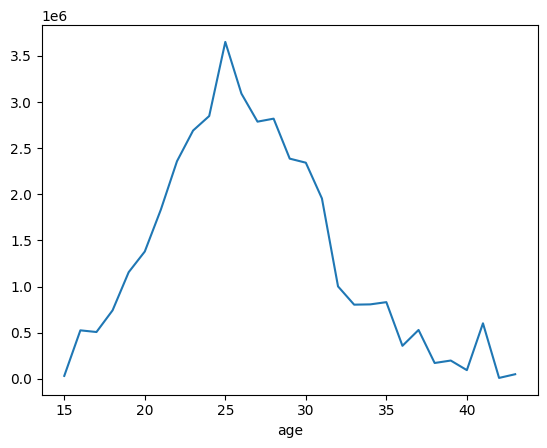

In [742]:
average_age = clean_platyers_df.groupby('age')['market_value'].mean()
average_age.plot(label="Average age")

<AxesSubplot: xlabel='position', ylabel='market_value'>

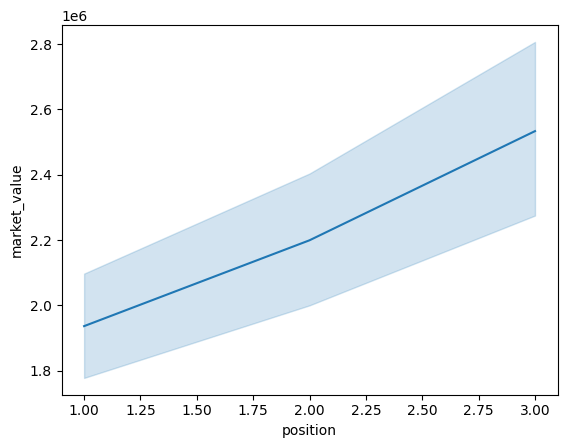

In [743]:
sns.lineplot(x=clean_platyers_df["position"], y=clean_platyers_df["market_value"])

##### Visualization – part 3:

The following histogram graph shows the amount of players according to their market value.

<AxesSubplot: xlabel='market_value', ylabel='Count'>

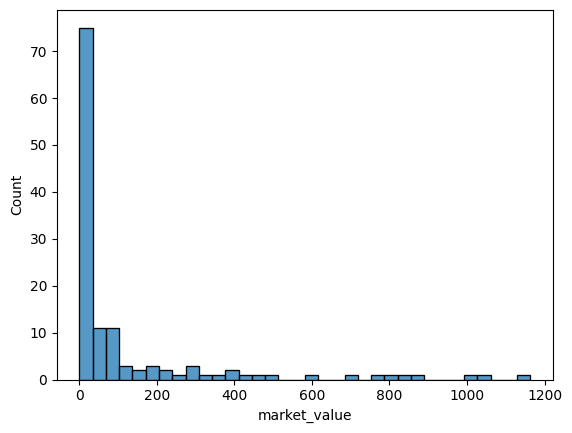

In [744]:
sns.histplot(x=clean_platyers_df["market_value"].value_counts())

##### Visualization – part 4:

In this part, we divided the “market_value” column in order to exclude the players with the lowest market value. The bins that determined:
•	10K-100K (10,000 – 100,000 euro)
•	100K-250K (100,000 – 250,000 euro)
•	250K-500K (250,000 – 500,000 euro)
•	500K-1M (500,000 – 1,000,000 euro)
•	1M-25M (1,000,000 – 25,000,000 euro)
•	25M-50M (25,000,000 – 50,000,000 euro)
•	+50M (50,000,000 euro and upper)
We believe that for players with a low market value (10K-100K, 100K-250K), the data is not accurate and as a result they may also harm the machine learning.
The pie graph shows the distribution of the players according to the categories of “market_value”.
Note: We divided into fields for data filtering. The target column is the original “market_value” column.

In [745]:
clean_platyers_df["market_value_binned"] = pd.cut(clean_platyers_df["market_value"], bins=[9999,100000, 250000, 500000, 1000000, 25000000, 50000000, 200000000], labels=["10K-100K", "100K-250K","250K-500K", "500K-1M", "1M-25M", "25M-50M", "50M+"])

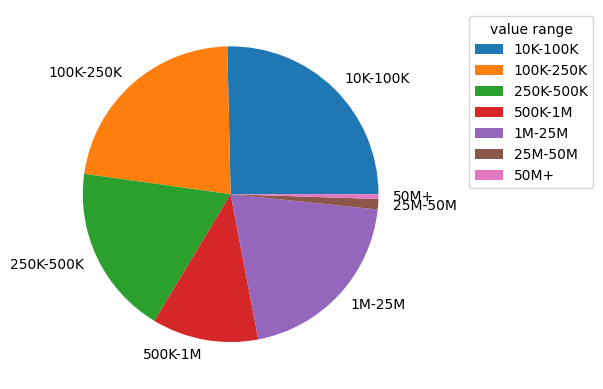

In [746]:
clean_platyers_df.groupby('market_value_binned').size().plot(kind='pie')
plt.legend(title="value range", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))

/var/folders/2q/0pvpsbfd0h30c9vs575k5tb40000gn/T/ipykernel_24518/256732587.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  clean_platyers_df.groupby(['age','market_value_binned']).size().groupby(level=0).apply(


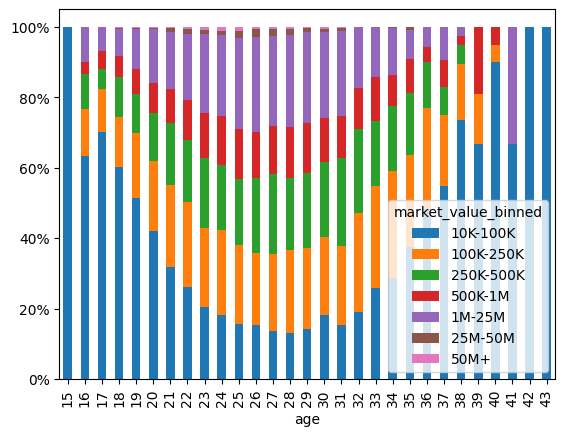

In [747]:
clean_platyers_df.groupby(['age','market_value_binned']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [749]:
df_copy = clean_platyers_df[clean_platyers_df["market_value_binned"] != "10K-100K"].copy()

/var/folders/2q/0pvpsbfd0h30c9vs575k5tb40000gn/T/ipykernel_24518/1436442182.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_copy.groupby(['age','market_value_binned']).size().groupby(level=0).apply(


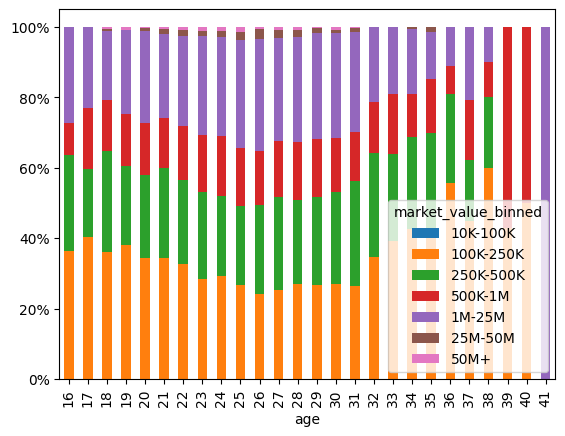

In [751]:
df_copy.groupby(['age','market_value_binned']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

##### Visualization – part 5:

The following bar plot shows the age distribution of the players.
We decided to divide the ages of the players into several groups because we think that there is no significant difference between certain ages. The age groups were determined as follows:
•	15-17
•	18-21
•	22-27
•	28-32
•	33-35
•	+36
Then, we will present the distribution of the market value of players after dividing the ages into groups in a bar plot.

<AxesSubplot: >

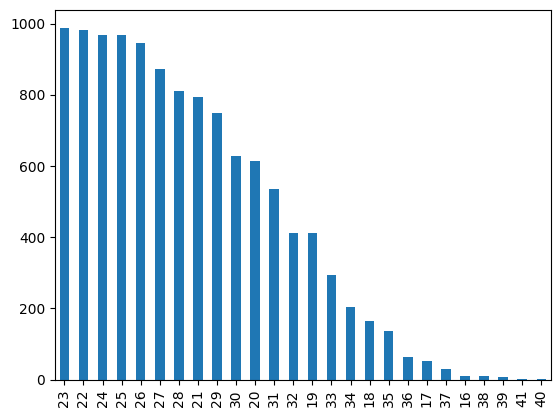

In [752]:
df_copy["age"].value_counts().plot.bar()

In [753]:
df_copy["age_binned"] = pd.cut(df_copy["age"], bins=[10, 18, 22, 27, 32, 36, 50], labels=[0,1,2,3,4,5])

/var/folders/2q/0pvpsbfd0h30c9vs575k5tb40000gn/T/ipykernel_24518/369152710.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_copy.groupby(['age_binned','market_value_binned']).size().groupby(level=0).apply(


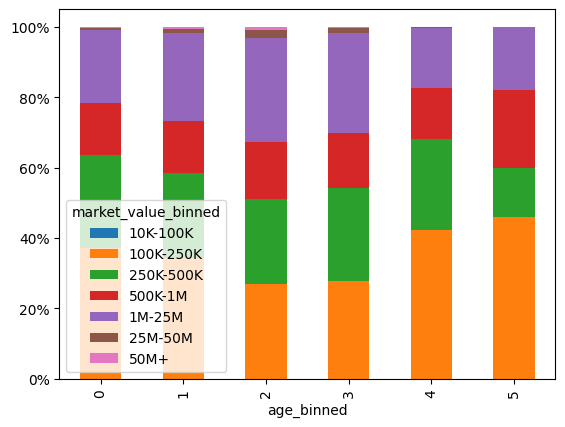

In [754]:
df_copy.groupby(['age_binned','market_value_binned']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

##### Visualization – part 6:

Now, we will present a bar plot that describes the relationship between the age of the players and the number of their appearances.

Text(0, 0.5, 'appearances')

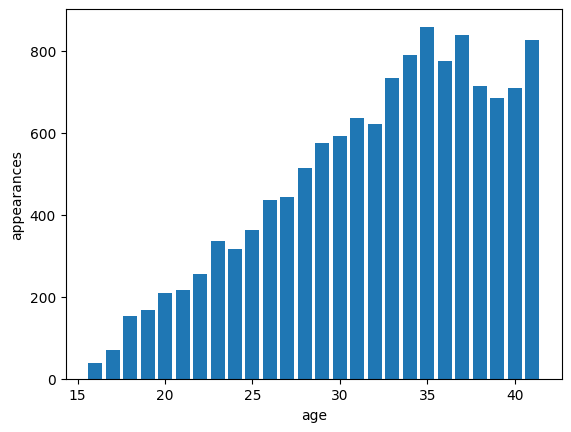

In [755]:
plt.bar(x=df_copy["age"], height=df_copy["appearances"])
plt.xlabel("age")
plt.ylabel("appearances")

##### Predict – part 1:

Now, we will drop some columns before starting the process of machine learning. The following columns are deleted:
•	Player 
•	Age (we divided the age column into groups)
•	Height (low connections with other columns)
•	Nationality
•	Country name
•	Market value binned (our target column is “market_value”)
In addition, we decided to convert the “club” column from string to numeric value because we want that this column will be included in machine learning. 
We used ‘LabelEnconder’ to convert the column to numeric value, as we studied in the course.

In [756]:
df_copy.drop(["player", "age", "height", "nationality", "market_value_binned","country_name"], axis=1, inplace=True)

In [757]:
df_copy["club"] = LabelEncoder().fit_transform(df_copy["club"])

##### Predict – part 2:

We created two functions of models for predicting the market value of the players:
1.	Linear regression – a model we learned about in the course.
2.	KNeighborsRegressor – a model that works in a similar way to the KNN model that we learned about in the course. It is intended for continuous variables.
In both models we used ‘MinMaxScaler’.
After several test, the test_size & random_state parameters that were sent to the functions of the models and resulted in the highest results:
•	Linear regression: test_size – 0.25, random_state – 41.
•	KNeighborsRegressor: test_size – 0.2, random_state – 41.

In [758]:
def linear_regression(data,target_col,test_size,random_state):
    lr = linear_model.LinearRegression()
    columns_list = data.columns[data.columns != target_col]
    X = data[columns_list]
    Y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    scaler = MinMaxScaler()
    scaled_X_train = scaler.fit_transform(X_train, y_train)
    scaled_X_test = scaler.transform(X_test)
    lr.fit(scaled_X_train, y_train)
    lr.predict(scaled_X_test)
    print("Linear Regression Train Score:", lr.score(scaled_X_train, y_train))
    print("Linear Regression Test Score:",lr.score(scaled_X_test,y_test))

In [759]:
def KNN(data,target_col,test_size,random_state):
    df_knn=data.copy()
    X=df_knn.drop([target_col],axis=1)
    y=df_knn[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    rmse_val = [] 
    score_train = []
    score_test = []
    for K in range(20):
        K = K+1
        model = KNeighborsRegressor(n_neighbors = K)

        model.fit(X_train, y_train) 
        pred=model.predict(X_test) 
        error = np.sqrt(metrics.mean_squared_error(y_test,pred)) 
        rmse_val.append(error)
        score_train.append(model.score(X_train,y_train))
        score_test.append(model.score(X_test,y_test))
    print("knn, rmse: ",min(rmse_val))
    k_best_ind=rmse_val.index(min(rmse_val))
    print("KNN Regression train score: ",score_train[k_best_ind])
    print("KNN Regression test score: ",score_test[k_best_ind])

In [778]:
linear_regression(df_copy,"market_value",0.2,42)

Linear Regression Train Score: 0.5679279314578454
Linear Regression Test Score: 0.5578070260349238


In [761]:
KNN(df_copy,"market_value",0.2,41)

knn, rmse:  5697421.847372113
KNN Regression train score:  0.6420424604178472
KNN Regression test score:  0.6173492585560503


#### Predict – conclusions

We can see that the results of the two models are remarkably similar:
•	Linear regression: 56%
•	KNeighborsRegressor: 61%
As we learned in the course, a result of over 50% success in the machine learning is considered successful. 
Therefore, it can be assumed that the market value of the players can be predicted according to their statistical data.

-----------------------------------------------------------------------------------Goalkeepers---------------------------------------------------------------------------------------------

##### Visualization – part 1:

First, we will present a “Heatmap” graph that describes relationships between numeric columns in the dataframe.

/var/folders/2q/0pvpsbfd0h30c9vs575k5tb40000gn/T/ipykernel_24518/1397173766.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(clean_goalkeepers_df.corr())


<AxesSubplot: >

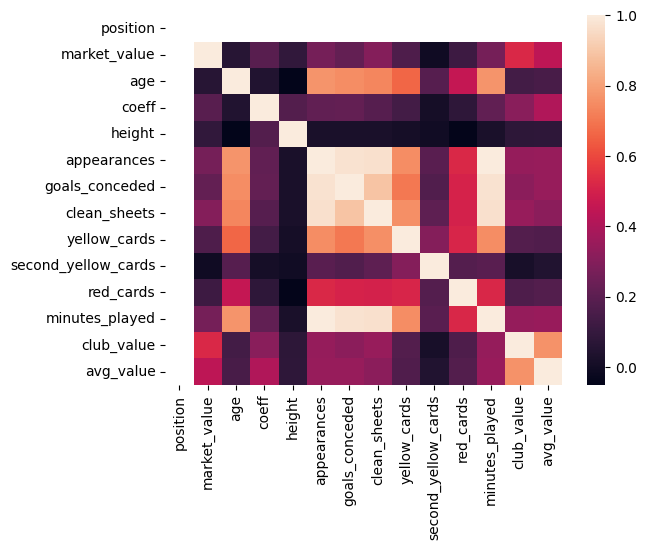

In [762]:
sns.heatmap(clean_goalkeepers_df.corr())

##### Visualization – part 2:

We will show now a line plot that showing the relationship between the ratio of the number of goals that a goalkeeper conceded to the number of his appearances, and his market value.

<AxesSubplot: ylabel='market_value'>

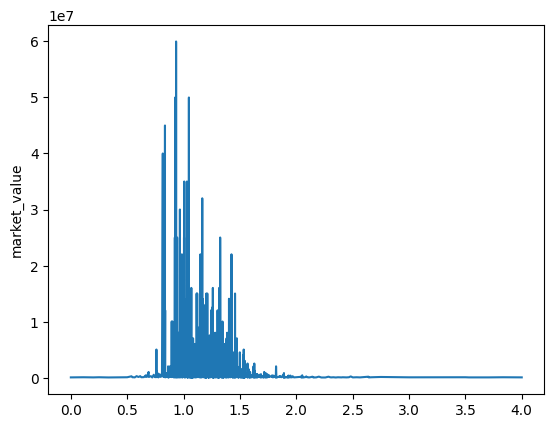

In [763]:
sns.lineplot(x=clean_goalkeepers_df["goals_conceded"]/clean_goalkeepers_df["appearances"], y=clean_goalkeepers_df["market_value"], errorbar=None)

##### Visualization – part 3:

We will describe a line plot that shows the connection between ‘clean_sheets’ column to 'market_value' column.

<AxesSubplot: xlabel='clean_sheets', ylabel='market_value'>

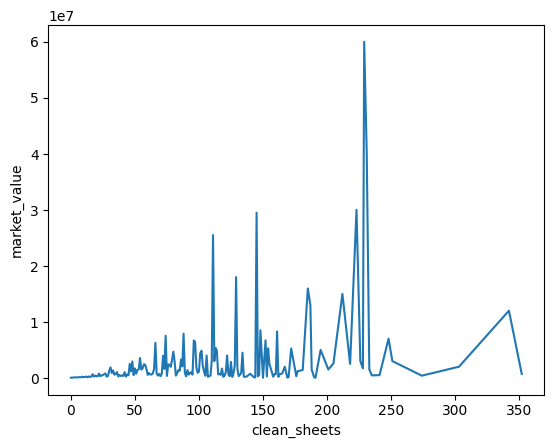

In [764]:
sns.lineplot(x=clean_goalkeepers_df["clean_sheets"], y=clean_goalkeepers_df["market_value"], errorbar=None)

<AxesSubplot: xlabel='market_value', ylabel='Count'>

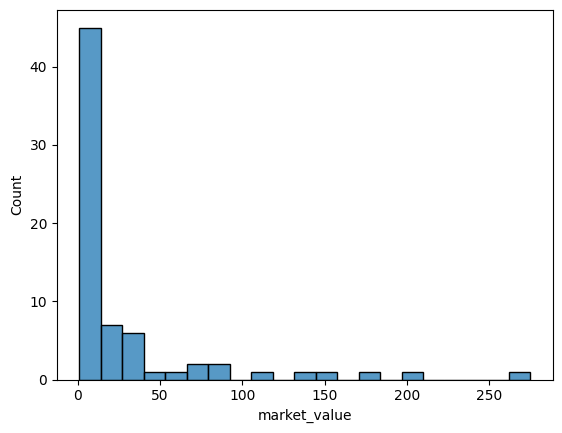

In [765]:
sns.histplot(x=clean_goalkeepers_df["market_value"].value_counts())

##### Visualization – part 4

As we have done in "Player dataframe", we will also divide the 'market_value' column into groups to filter goalkeepers with low market value. The bins that determined:
•	10K-100K (10,000 – 100,000 euro)
•	100K-250K (100,000 – 250,000 euro)
•	250K-500K (250,000 – 500,000 euro)
•	500K-1M (500,000 – 1,000,000 euro)
•	1M-25M (1,000,000 – 25,000,000 euro)
•	25M-50M (25,000,000 – 50,000,000 euro)
•	+50M (50,000,000 euro and upper)
We believe that for goalkeepers with a low market value (10K-100K, 100K-250K), the data is not accurate and as a result they may also harm the machine learning.
The pie graph shows the distribution of the goalkeepers according to the categories of “market_value”.
Note: We divided into fields for data filtering. The target column is the original “market_value” column.


In [766]:
clean_goalkeepers_df["market_value_binned"] = pd.cut(clean_goalkeepers_df["market_value"], bins=[9999, 50000, 100000, 250000, 500000, 1000000, 25000000, 50000000, 200000000], labels=["10K-50K","50K-250K", "100K-250K","250K-500K", "500K-1M", "1M-25M", "25M-50M", "50M+"])

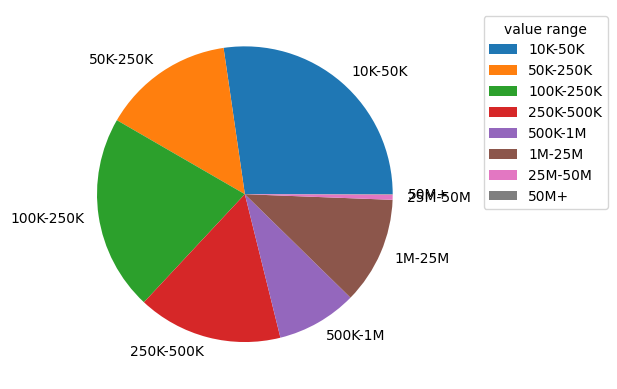

In [767]:
clean_goalkeepers_df.groupby('market_value_binned').size().plot(kind='pie')
plt.legend(title="value range", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))

/var/folders/2q/0pvpsbfd0h30c9vs575k5tb40000gn/T/ipykernel_24518/1414027845.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  clean_goalkeepers_df.groupby(['age','market_value_binned']).size().groupby(level=0).apply(


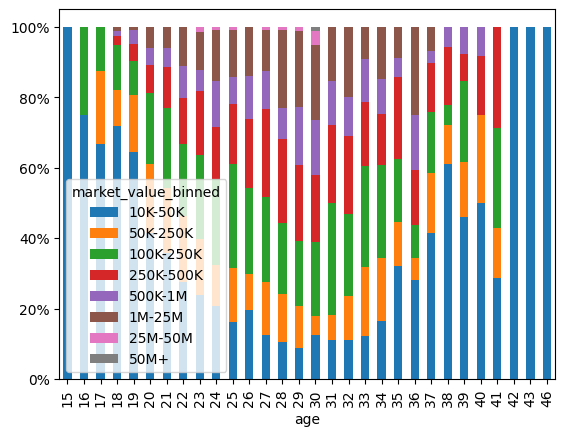

In [768]:
clean_goalkeepers_df.groupby(['age','market_value_binned']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [769]:
df_copy_gk = clean_goalkeepers_df.copy()

#### Visualization – part 5:

The following bar plot shows the age distribution of the goalkeepers.
We decided to divide the ages of the goalkeepers into several groups because we think that there is no significant difference between certain ages. The age groups were determined as follows:
•	15-17
•	18-21
•	22-27
•	28-32
•	33-35
•	+36
Then, we will present the distribution of the market value of goalkeepers after dividing the ages into groups in a bar plot.


<AxesSubplot: >

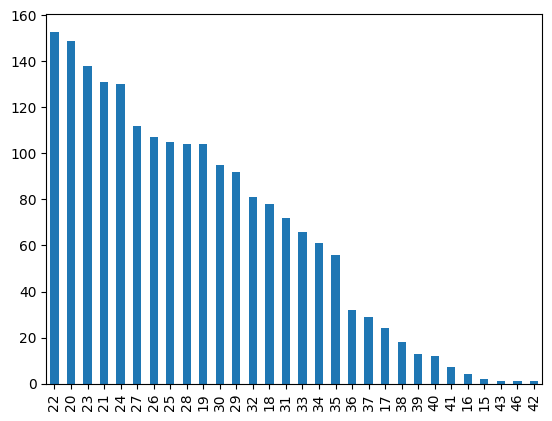

In [770]:
df_copy_gk["age"].value_counts().plot.bar()

In [771]:
df_copy_gk["age_binned"] = pd.cut(df_copy_gk["age"], bins=[14, 18, 22, 27, 32, 36, 50], labels=[0,1,2,3,4,5])

/var/folders/2q/0pvpsbfd0h30c9vs575k5tb40000gn/T/ipykernel_24518/2610141417.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_copy_gk.groupby(['age_binned','market_value_binned']).size().groupby(level=0).apply(


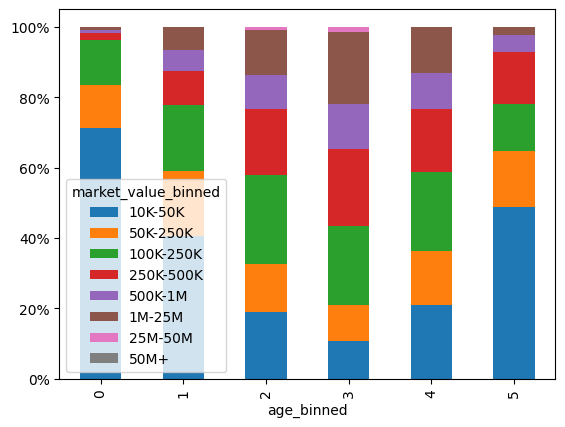

In [772]:
df_copy_gk.groupby(['age_binned','market_value_binned']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#### Visualization – part 6:

Now, we will present a bar plot that describes the relationship between the age of the goalkeepers and the number of their appearances.

Text(0, 0.5, 'appearances')

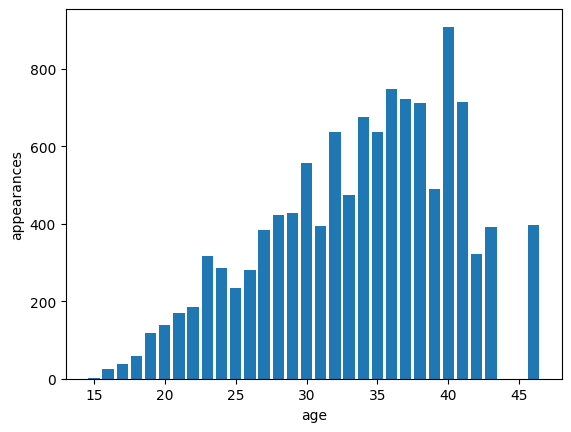

In [773]:
plt.bar(x=df_copy_gk["age"], height=df_copy_gk["appearances"])
plt.xlabel("age")
plt.ylabel("appearances")

#### Predict – part 1:

Now, we will drop some columns before starting the process of machine learning. The following columns are deleted:
•	Player 
•	Age (we divided the age column into groups)
•	Height (low connections with other columns)
•	Nationality
•	Country name
•	Market value binned (our target column is “market_value”)
In addition, we decided to convert the “club” column from string to numeric value. We used ‘LabelEnconder’ to convert the column to numeric value.

In [774]:
df_copy_gk.drop(["player", "age", "height", "nationality", "market_value_binned","country_name"], axis=1, inplace=True)

In [775]:
df_copy_gk["club"] = LabelEncoder().fit_transform(df_copy_gk["club"])

##### Predict – part 2:

We created two functions of models for predicting the market value of the players:
1.	Linear regression 
2.	KNeighborsRegressor 
In both models we used ‘MinMaxScaler’.
After several test, the test_size & random_state parameters that were sent to the functions of the models and resulted in the highest results:
•	Linear regression: test_size – 0.3, random_state – 41.
•	KNeighborsRegressor: test_size – 0.35, random_state – 41.


In [776]:
linear_regression(df_copy_gk,"market_value",0.3,41)

Linear Regression Train Score: 0.324034889213742
Linear Regression Test Score: 0.3016272960135674


In [777]:
KNN(df_copy_gk,"market_value",0.35,41)

knn, rmse:  3320530.6978254304
KNN Regression train score:  0.4313069472454898
KNN Regression test score:  0.3042410523942004


#### Predict – conclusions

We can see that the results of the two models are remarkably similar:
•	Linear regression: 30%
•	KNeighborsRegressor: 30%
Surprisingly, the prediction for the goalkeepers did not worked in both models. 
Therefore, we conclude that the market value of the goalkeepers cannot be predicted based on their statistics.